# The One Goal for Today

To implement and train a from input to hidden of a RBF network using python.

# RBF Networks with the car logo data

Review: training a RBF consists of:
* Finding prototypes
* Selecting the activation function for the hidden nodes
* Selecting the activation function for the output nodes
* Setting (or fitting) the weights for the edges and biases

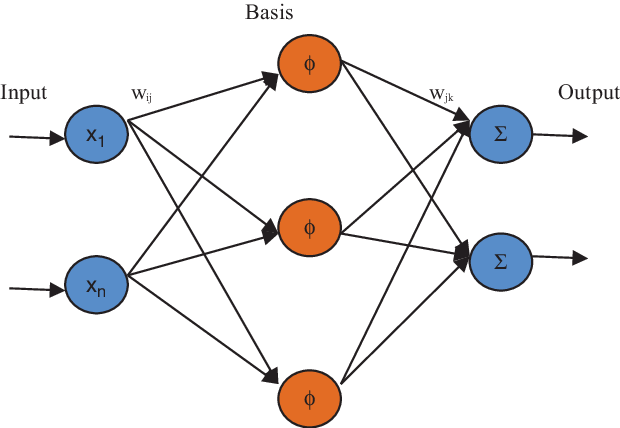

*Image source: https://www.researchgate.net/figure/Structure-of-radial-basis-function-neural-network_fig1_330557075*

## Load the Data

We will keep using the car logo dataset!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [2]:
data = np.array(np.genfromtxt('data/logos.csv', delimiter=',', dtype=int))  

# Look at the Data

In [3]:
def getSummaryStatistics(data):
    "Get the max, min, mean, var for each variable in the data."
    return pd.DataFrame(np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0), data.var(axis=0)]))

def getShapeType(data):
    "Get the shape and type of the data."
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
getShapeType(data)

          0            1            2            3            4     \
0   255.000000   255.000000   255.000000   255.000000   255.000000   
1     1.000000     0.000000     0.000000     1.000000     0.000000   
2    98.911765    98.702206    99.128676    99.816176   100.176471   
3  5333.473832  5341.503230  5263.031236  5092.436797  4937.854888   

          5            6            7            8            9     ...  \
0   255.000000   255.000000   255.000000   255.000000   255.000000  ...   
1     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
2   100.419118   101.363971   103.575368   105.222426   106.459559  ...   
3  4825.875811  4698.058702  4764.869320  4950.536924  4909.505717  ...   

          1015         1016         1017         1018         1019  \
0   255.000000   255.000000   246.000000   240.000000   254.000000   
1     0.000000     0.000000     0.000000     0.000000     0.000000   
2    83.446691    83.165441    82.266544    81.900735    83.011

((544, 1025), dtype('int64'))

## What kind of analysis are we going to do?

Regression, clustering, classification?

If supervised, which is our dependent variable?

If we have a dependent variable, how many possible values does it have? What will this number correspond to in the RBF network?

Questions:
* *In the below, why do we shuffle?*
* *In the below, why do we split into train and test?*

In [4]:
# Why are we doing this?
np.random.shuffle(data)

# Why are we doing this?
train_data, test_data = np.split(data, [int(.8 * len(data))])
print(getSummaryStatistics(train_data))
print(getSummaryStatistics(test_data))

          0            1            2            3            4     \
0   255.000000   255.000000   255.000000   255.000000   255.000000   
1     1.000000     0.000000     2.000000     1.000000     1.000000   
2    97.179310    97.280460    97.864368    98.395402    98.452874   
3  5192.850606  5197.056975  5075.312638  4956.717220  4795.181112   

          5           6            7            8            9     ...  \
0   255.000000   255.00000   255.000000   255.000000   255.000000  ...   
1     0.000000     0.00000     0.000000     0.000000     0.000000  ...   
2    99.227586   100.11954   102.809195   104.427586   105.491954  ...   
3  4657.996480  4508.16502  4662.292329  4845.495331  4903.054533  ...   

          1015         1016         1017         1018         1019  \
0   255.000000   255.000000   243.000000   240.000000   254.000000   
1     0.000000     1.000000     0.000000     0.000000     0.000000   
2    83.055172    81.786207    80.593103    80.006897    81.101149  

In [5]:
y_train = train_data[:, -1]
x_train = train_data[:, 0:-1]
y_test = test_data[:, -1]
x_test = test_data[:, 0:-1]

## Does the data need to be cleaned?

Are there missing or erroneous values? 

Do we need to fix the types of some of the variables?

## Does it need to be normalized?

Is the range of one or more values clearly out of line with the rest?

## Consider transformation

Would PCA help? Yes, probably! We will reuse the code from day 30.

In [6]:
def prep_pca(data):
    # center data
    centered_data = data - np.mean(data, axis=0)
    # covariance matrix
    covariance_matrix = (centered_data.T @ centered_data) / (data.shape[0] - 1)
    # singular value decomposition
    evals, evectors = scipy.linalg.eigh(covariance_matrix)
    # sort eigenvals, eigenvecs
    order = np.argsort(evals)[::-1]
    eigenvals_sorted = evals[order]
    eigenvecs_sorted = evectors[:, order]
    return centered_data, covariance_matrix, eigenvals_sorted, eigenvecs_sorted

def plot_covariance_matrix(covariance_matrix):
    fig = plt.figure(figsize=(12,12))
    sns.heatmap(pd.DataFrame(covariance_matrix), annot=False, cmap='PuOr')
    plt.show()

def plot_eigenvectors(eigenvecs_sorted):
    fig = plt.figure(figsize=(14,3))
    sns.heatmap(pd.DataFrame(eigenvecs_sorted[:, 0:21].T), 
                annot=False, cmap='coolwarm',
               vmin=-0.5,vmax=0.5)
    plt.ylabel("Ranked Eigenvalue")
    plt.xlabel("Eigenvector Components")
    plt.show()

def get_proportional_variances(eigenvals_sorted):
    sum = np.sum(eigenvals_sorted)
    proportional_variances = np.array([eigenvalue / sum for eigenvalue in eigenvals_sorted])
    cumulative_sum = np.cumsum(proportional_variances)
    return proportional_variances, cumulative_sum

def scree_graph(proportional_variances):
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(proportional_variances)), proportional_variances, alpha=0.5, align='center',
            label='Proportional variance')
    plt.ylabel('Proportional variance ratio')
    plt.xlabel('Ranked Principal Components')
    plt.title("Scree Graph")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def elbow_plot(cumulative_sum):
    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)
    ax1.plot(cumulative_sum)
    ax1.set_ylim([0,1.0])
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Cumulative explained variance')
    ax1.set_title('Elbow Plot')
    plt.show()

def fit_pca(centered_data, eigenvecs_sorted, number_to_keep):
    v = eigenvecs_sorted[:, :number_to_keep]
    projected_data = centered_data@v
    return projected_data

As we know from day 30, we will keep 200 dimensions.

In [7]:
centered_train, covariance_matrix, eigenvals_sorted, eigenvecs_sorted = prep_pca(x_train)
projected_train = fit_pca(centered_train, eigenvecs_sorted, 200)
centered_test = x_test - np.mean(x_train, axis=0)
projected_test = fit_pca(centered_test, eigenvecs_sorted, 200)

# Find Prototypes

To do this, we use kmeans. I am going to use the scikit-learn implementation; you should use your own for the project.

Questions:
* *What will our number of prototypes be?*
* *Where does that belong in the RBFNet diagram earlier in this notebook?*
* *Why would we not just have the number of prototypes be equal to the number of classes?*

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
[[2.00000000e+00 1.54446735e+09]
 [3.00000000e+00 1.42285951e+09]
 [4.00000000e+00 1.35049737e+09]
 [5.00000000e+00 1.30277614e+09]
 [6.00000000e+00 1.27084936e+09]
 [7.00000000e+00 1.24426337e+09]
 [8.00000000e+00 1.23057607e+09]
 [9.00000000e+00 1.20919245e+09]
 [1.00000000e+01 1.18325298e+09]
 [1.10000000e+01 1.16292996e+09]
 [1.20000000e+01 1.15400375e+09]
 [1.30000000e+01 1.13520352e+09]
 [1.40000000e+01 1.12828730e+09]
 [1.50000000e+01 1.11873260e+09]
 [1.60000000e+01 1.10070628e+09]
 [1.70000000e+01 1.09740603e+09]
 [1.80000000e+01 1.07107243e+09]
 [1.90000000e+01 1.07794910e+09]
 [2.00000000e+01 1.06736868e+09]
 [2.10000000e+01 1.05727862e+09]
 [2.20000000e+01 1.04451932e+09]
 [2.30000000e+01 1.03938930e+09]
 [2.40000000e+01 1.02570774e+09]
 [2.50000000e+01 1.02545341e+09]
 [2.60000000e+01 1.00542495e+09]
 [2.70000000e+01 1.00242435e+09]
 [2.80000000e+01 9.99856966e+08]
 [2

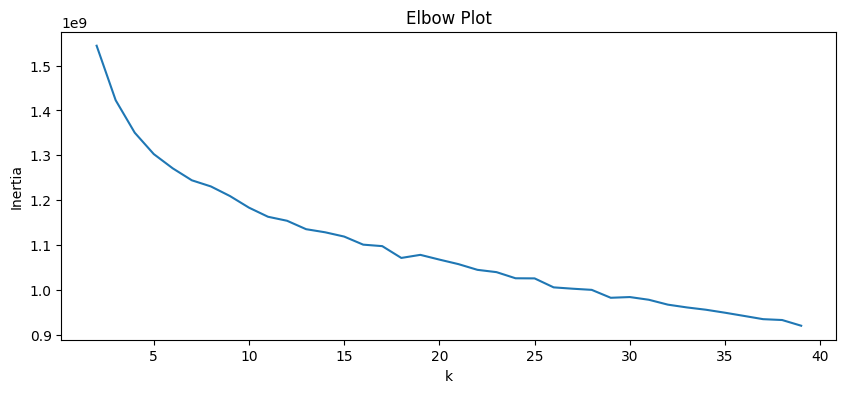

In [9]:
from sklearn.cluster import KMeans

inertia_by_k = []

for k in range(2, 40):
    print(k)
    km = KMeans(n_clusters=k, random_state=0, n_init = 10).fit(projected_train)
    inertia_by_k.append([k, km.inertia_])

inertia_by_k = np.array(inertia_by_k)
print(inertia_by_k)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)
ax1.plot(inertia_by_k[:, 0], inertia_by_k[:, 1])
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot')
plt.show()


So, what value will we choose for k? 

In [10]:
k = 18

km = KMeans(n_clusters=k, random_state=0, n_init=10).fit(projected_train)

print(km.cluster_centers_)

[[ 7.67503894e+01 -2.22625536e+02 -1.74238620e+02 ... -4.19166644e+00
  -1.61311076e+00 -2.87459647e+00]
 [-1.75635948e+03  6.88645531e+02  2.21748000e+02 ... -6.09099198e+00
  -6.81284393e-01  9.15536464e+00]
 [-2.76155503e+03 -2.23091176e+02 -1.73765873e+02 ...  9.22981185e+00
  -2.66682464e-01  7.90498168e-01]
 ...
 [ 5.05736552e+02 -5.49209804e+02 -3.53626143e+01 ... -7.07312516e+00
  -5.60205061e+00  5.67642780e+00]
 [ 1.19190808e+03 -3.30461283e+02  2.70940340e+02 ...  1.40496890e+01
   1.34557654e+01 -8.09963586e+00]
 [ 8.68252593e+02  3.52045326e+02  8.83270978e+01 ... -2.32595997e+00
   1.13663099e+00 -7.37211704e+00]]


# Define the Activation Function for the Hidden Nodes

Recall that a typical activation function for the hidden nodes is the Gaussian, so something like $exp \left( - \frac{||\vec{d}-\vec{\mu_j}||^2}{2\delta_j^2 + \epsilon} \right)$, where $\vec{d}$ is the data point, $\vec{\mu_j}$ is the prototype, $\delta_j$ is the hidden unit's standard deviation, $\epsilon$ is a small constant and $||.||^2$ is the squared Euclidean distance.

Let's take a good look at this activation function. 

Questions:
* *What is in the numerator? Why look, it's the distance! Why would we not just use the distance itself as the activation function?* 
* *What is the function of $\delta_j$?*
* *Why do we have $\epsilon$?*

In the cell below. you should define a function that will return the activations for the hidden nodes.

In [ ]:
def calculateActivations(data, kmeans_clustering):
    outputs = []
    eps = 0.001
    sigma = avg_cluster_dist(data, kmeans_clustering)
    for d in data:
        c = centroid for d
        # or use numpy.linalg.norm
        num = np.sum(d - c)**2
        denom = 2*sigma + eps
        frac = - num / denom
        output = np.exp(frac)
        outputs.append(output)
    return outputs

In [ ]:
train_calcs = calculateActivations(projected_train, km)
print(train_calcs.shape)

test_calcs = calculateActivations(projected_test, km)
print(test_calcs.shape)

# What Will We Do When We Get a New Data Point?

At this point, we have defined:
* The input layer (ish)
* The hidden layer

For a new data point, we will:
1. encode it using the same method we used for train, including any summary statistics **on the training data**
2. "send it" to each of the hidden layer nodes (so the weights from the input layer to the hidden layer are all 1) - this is really just a matrix multiply!
3. each hidden layer node will calculate its activation for this data point - more matrix multiply!

Next class session we will define the output layer, and explain how it relates to another analysis method we already know well, linear regression. We will then show how we can *use RBF networks for classification AND regression*!

To facilitate that, let's save our processed data.

In [ ]:
import pickle as pkl

In [ ]:
pkl.dump(train_calcs, open("../hidden_node_weights_train.pkl",'wb'))
pkl.dump(y_train, open("../labels_train.pkl",'wb'))
pkl.dump(test_calcs, open("../hidden_node_weights_test.pkl",'wb'))
pkl.dump(y_test, open("../labels_test.pkl",'wb'))